In [1]:
import numpy as np
from numpy import linalg as LA
from sympy.physics.quantum.dagger import Dagger
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm
from time import time

# Functional definitions 

In [2]:
# some more function for ease..

def conjT(A):
    B = np.conj(A)
    B = np.transpose(B)
    return B

def vec_norm(v):
    norm = conjT(v)@v
    return np.sqrt(norm[0,0])

def vec_prod(u,v):
    norm = conjT(u)@v
    return norm[0,0]

def fun(x,s=1):
    tol=1e-6
    if abs(x)<tol:
        return 1
    else:
        return np.exp(1j*x*s/2)*np.sin(x*s/2)/(x/2) 

# The shift operator
We define the shift operator by,
\begin{equation}
S=|0\rangle\langle0|\otimes \sum_k |k+1\rangle\langle k|+|1\rangle\langle1|\otimes \sum_k |k-1\rangle\langle k|\,.
\end{equation}
In what follows
\begin{equation}
Sp=|0\rangle\langle0|\otimes \sum_k |k+1\rangle\langle k|\,,
\end{equation}
and
\begin{equation}
Sm=|1\rangle\langle1|\otimes \sum_k |k-1\rangle\langle k|\,.
\end{equation}

# The unitary operator
The unitary operator is defined as,
\begin{equation}
U=S\cdot\left(\mathbf{C}\otimes\mathbf{I}_{p}\right)\,.
\end{equation}

In [3]:
# Coin parameters

c=np.eye(2)
θ=np.pi/4
α=0
β=0
cc=np.cos(θ)*np.exp(1j*α)*np.outer(c[0],c[0])+np.sin(θ)*np.exp(1j*β)*np.outer(c[0],c[1])-np.sin(θ)*np.exp(-1j*β)*np.outer(c[1],c[0])+np.cos(θ)*np.exp(-1j*α)*np.outer(c[1],c[1])

N=100           # total time steps
P=2*N+1       # total position coordinates
vec=np.eye(P) # dimension of position vector space..

coin=np.kron(vec,cc) # coin operator

# Shift Operator
Sp=np.zeros((2*P,2*P))
for i in range(P-1):
    Sp=Sp+np.kron(np.outer(vec[i+1],vec[i]),np.outer(c[0],c[0])) # Sp
Sm=np.zeros((2*P,2*P))
for i in range(1,P):
    Sm=Sm+np.kron(np.outer(vec[i-1],vec[i]),np.outer(c[1],c[1])) # Sm

shift=Sp+Sm # Total shift operator S=Sp+Sm

U=shift@coin # Unitary operator


# The density operator and purification

We define the initial state placed at the origin (which in our notation is at $x=k$) and symmetric in the coin space.
\begin{equation}
|\psi_0\rangle=\frac{|0\rangle+i |1\rangle}{\sqrt{2}}\otimes |0\rangle\,.
\end{equation}
The final state after $t-$steps of evolution is given by,
\begin{equation}
|\Psi_t\rangle=\mathbf{U}^t|\Psi_0\rangle\,.
\end{equation}
The corresponding reduced density matrix
\begin{equation}
\rho_r=\text{Tr}_{\vec{x}}|\Psi_t\rangle\langle\Psi_t|\,,
\end{equation}
is a $2\times2$ matrix signifying a mixed state. Denoting the eigenbasis of the reduced matrix by $(\omega,\vec{v})$, we can write the corresponding canonically purified state to be,
\begin{equation}
|\Psi\rangle_{pure}=\sum_i \sqrt{w_i}|\vec{v}_i\rangle\otimes |\vec{v}_i\rangle\,.
\end{equation} 


In [10]:
# Initial wave function
ξ=(c[0]+1j*c[1])/(np.sqrt(2))
pos0=np.zeros(P)
pos0[N]=1
ψ=np.kron(pos0,ξ)

# Density operator and reduced density operator
ϕ=[]
ent=[]
for i in range(N+1):
    ρ=np.outer(np.conjugate(ψ),ψ).reshape([P,2,P,2])
    ρ_red=np.trace(ρ,axis1=0,axis2=2)
    ent.append(-np.trace(ρ_red@logm(ρ_red)))
# Eigenvalues and Eigenvectors
    w,v= LA.eig(ρ_red)
# Canonically Purified 2-qubit state
    ϕ.append(np.sqrt(w[0])*np.kron(v[0],v[0])+np.sqrt(w[1])*np.kron(v[1],v[1])) 
    ψ=U@ψ

/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


# Entanglement of purification with steps

/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


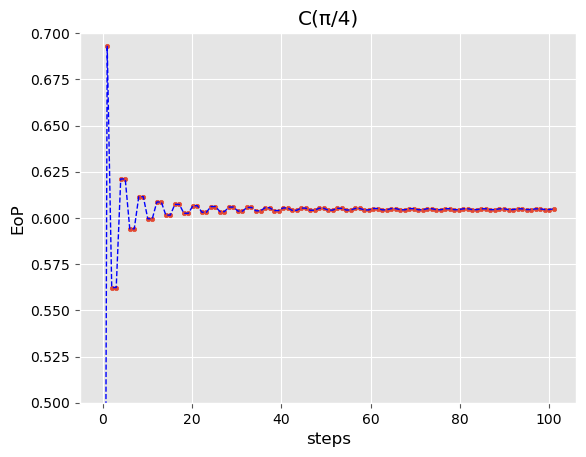

In [33]:
x=np.linspace(0,N+1,N+1)
y=np.round(ent,6)
plt.style.use('ggplot')
plt.scatter(x,y,s=10)
plt.plot(x,y,linestyle='--',linewidth=1,color='blue')
plt.ylim([0.5,0.7])
plt.xticks(color='black')
plt.yticks(color='black')
plt.xlabel('steps',color='black')
plt.ylabel('EoP',color='black')
plt.title('C(π/4)')
plt.savefig('EoP.pdf')
plt.show()

# Target unitary operator
Our complexity computation starts with the computation of the target unitary operator $U_{t}$ given by,
\begin{equation}
|\Psi_{pure}(t)\rangle=U_t|\Psi_0\rangle\,,
\end{equation}
where $|\Psi_0\rangle=|00\rangle$ is an unentangled reference state. However a complexity determined from $U_t$ determines the complexity of the quantum circuit at the end of the $t-$ steps of evolution while ignoring the intermediate steps. To solve this we implement the circuit step-wise using,
\begin{equation}
|\Psi_{pure}(t)\rangle=U_t U_{t-1}^\dagger|\Psi_{pure}(t-1)\rangle\,.
\end{equation}
Hence our refined target unitary operator is,
\begin{equation}
U'_t=U_t U_{t-1}^\dagger\,.
\end{equation}
The unitary operator is obtained by a recursive Gram-Schmidt orthogonalization process, where,
\begin{equation}
U_t=(\textbf{u},\textbf{u}_1,\textbf{u}_2, \textbf{u}_3)
\end{equation}
where $\textbf{u}=\Psi_{pure}(t)$ and $\textbf{u}_i$ are column vectors, given by, 
\begin{equation}
\textbf{u}_i=\textbf{v}_i-\sum_{j=1}^{i-1}\frac{\langle\textbf{v}_i,\textbf{u}_j\rangle}{\langle\textbf{u}_j,\textbf{u}_j\rangle}\textbf{u}_j\,.
\end{equation}
We start with $\textbf{v}_i$ as some random complex unit vectors. The resultant vectors satisfy,
\begin{equation}
\langle\textbf{u}_i,\textbf{u}_j\rangle=\delta_{ij}\,.
\end{equation}
and by extension $U^\dagger U=U U^\dagger=\mathbb{I}_2$. However, there are infinite choices for the starting unit vectors $\textbf{v}_i$ to lie on the unit $S_4$. There are two options: 1) Either we parameterize the vectors with unit $S_4$ parameters or 2) we assign complex random values $(0,1)$ to the vectors satisfying the normalization conditions. Both choices are equivalent. For a completely numerical purpose, we choose to proceed with the method 2).   

In [5]:
def Ut(Ψ):
    U= np.zeros((4,4),dtype = 'complex')
    U[:,0] = Ψ
    u = [U[:,[0]]]
    for i in range(3):
        v = np.random.uniform(0,1,size= (4,1)) + 1j*np.random.uniform(0,1,size= (4,1)) # Generate a random-vector  
        for j in range(len(u)):
            v = v - vec_prod(u[j],v)*u[j]
        v = v/vec_norm(v)
        u.append(v)
        U[:,[i+1]] = v  
    U=U/(LA.det(U)**(1/4))    
    return U

# Random Sampling 
To proceed with method 2), we choose a random sampling with sample size of $~500$. The size is chosen so that the standard deviation of the complexity approaches a constant value with the specified sample.

In [6]:
def sample_gen(Ψ1,Ψ2,sample_size):
    Us=[]
    for k in range(sample_size):
        U1=Ut(Ψ1)
        U2=Ut(Ψ2)
        Us.append(U2@conjT(U1))
    return Us    


In [7]:
def Sample_Gen(Ψ1,sample_size):
    Us=[]
    for k in range(sample_size):
        U1=Ut(Ψ1)
        Us.append(Ut(Ψ1))
    return Us 

In [7]:
def complexity(U,μ=100):
    α=2*μ/(1+μ)
    u1=logm(U)
    c=np.array([1j/4*(u1[0, 2] + u1[1, 3] + u1[2, 0] + u1[3, 1]), 1/4*(-u1[0, 2] - u1[1, 3] + u1[2, 0] + u1[3, 1]), 
    1j/4*(u1[0, 1] + u1[1, 0] - u1[2, 3] - u1[3, 2]), 1/4*(-u1[0, 1] + u1[1, 0] + u1[2, 3] - u1[3, 2]), -(1j/2)*(u1[0, 0] + u1[1, 1]), 
    1/4*(-u1[0, 3] - u1[1, 2] + u1[2, 1] + u1[3, 0]), -(1j/4)*(u1[0, 3] + u1[1, 2] + u1[2, 1] + u1[3, 0]),-1j/4*(u1[0, 3] - u1[1, 2] - u1[2, 1] + u1[3, 0]), 
    1/4*(u1[0, 3] - u1[1, 2] + u1[2, 1] - u1[3, 0]), -(1j/2)*(u1[0, 0] + u1[2, 2]), 1j/4*(u1[0, 1] + u1[1, 0] + u1[2, 3] + u1[3, 2]), 
    1/4*(-u1[0, 1] + u1[1, 0] - u1[2, 3] + u1[3, 2]), 1j/4*(u1[0, 2] - u1[1, 3] + u1[2, 0] - u1[3, 1]), 
    1/4*(-u1[0, 2] + u1[1, 3] + u1[2, 0] - u1[3, 1]), -(1j/2)*(u1[1, 1] + u1[2, 2])])
    
    f=np.sum((c[:10])**2)
    
    M = α*np.array([[0,-c[9],c[8],-c[7],-c[3]],[c[9],0,-c[6],c[5],c[2]],[-c[8],c[6],0,-c[4],-c[1]],[c[7],-c[5],c[4],0,c[0]],[c[3],-c[2],c[1],-c[0],0]])
    
    ω,σ = LA.eig(M)
    Ss=np.zeros((5,5),dtype='complex')
    for k in range(len(ω)):
        Ss=Ss+fun(ω[k])*np.outer(σ[k],σ[k])

    v_init=LA.inv(Ss)@np.transpose([c[10:15]])

    X=np.linspace(0,1,1000)
    com=np.zeros_like(X,dtype='complex')
    for s in range(len(X)):
        Ssp=np.zeros((5,5),dtype='complex')
        for i in range(len(ω)):
            Ssp=Ssp+fun(ω[i],X[s])*np.outer(σ[i],σ[i])
        col=Ssp@v_init
        com[s]= np.sqrt(f+(1+μ)*np.sum(col**2))
    return np.trapz(X,np.real(com))    
    

# Complexity
We construct the operator,
\begin{equation}
U(s)=\mathcal{P}\exp\left(-i\int_0^s ds'V_i(s')T_i\right)
\end{equation}
where $T_i\in SU(4)$ and of the explicit form,
\begin{equation}
T_i=i^\binom{q}{2}\gamma_1^{b_1}\cdots\gamma_N^{b_N}\,,
\end{equation}
where $b_i\in\mathcal{B}_N$ is the binary bit representation of the integers $\mathcal{B}_N\in(1,15)$. $\gamma_a$ are the Majorana fermionic operators. We also associate the notion of $k-$ locality in the sense that $T_i$ are up to $k$ local if they have $k$ or fewer $\gamma_a$. $V_i(s)$ satisfy the geodesic equations,
\begin{equation}
G_{ij}\frac{dV^j}{ds}=f_{ij}^p V^j G_{pl}V^l\,.
\end{equation}
$G_{ij}=c_i\delta_{ij}$ is the metric bilinear form and $c_i$ are the cost functions associated with $k-$ locality,
\begin{equation}
c_i=\begin{cases} 1\,, \ i\leq k\\ 1+\mu\,, \ \text{otherwise}\end{cases}
\end{equation}
$\log U(s=1)=\log U_{target}$ relates the coefficients $V_i(s)$ to $U_{target}$ obtained from the $1d$ random walk. The complexity is then,
\begin{equation}
C(U)=\text{min}\int_0^1 ds\sqrt{G_{ij}V^i(s)V^j(s)}\,.
\end{equation}
For the purpose of constructing explicit $U(s)$ the geodesic solutions as non-trivial functions of the affine parameter $(s)$ are useful, but for the complexity, they are non essential since the linear combination of the squares are always independent of $s$.  

In [8]:
def complexity(U,x,μ=100):
    α=2*μ/(1+μ)
    u1=logm(U)
    sol=np.array([1j/4*(u1[0, 2] + u1[1, 3] + u1[2, 0] + u1[3, 1]), 1/4*(-u1[0, 2] - u1[1, 3] + u1[2, 0] + u1[3, 1]), 
    1j/4*(u1[0, 1] + u1[1, 0] - u1[2, 3] - u1[3, 2]), 1/4*(-u1[0, 1] + u1[1, 0] + u1[2, 3] - u1[3, 2]), -(1j/2)*(u1[0, 0] + u1[1, 1]), 
    1/4*(-u1[0, 3] - u1[1, 2] + u1[2, 1] + u1[3, 0]), -(1j/4)*(u1[0, 3] + u1[1, 2] + u1[2, 1] + u1[3, 0]),-1j/4*(u1[0, 3] - u1[1, 2] - u1[2, 1] + u1[3, 0]), 
    1/4*(u1[0, 3] - u1[1, 2] + u1[2, 1] - u1[3, 0]), -(1j/2)*(u1[0, 0] + u1[2, 2]), 1j/4*(u1[0, 1] + u1[1, 0] + u1[2, 3] + u1[3, 2]), 
    1/4*(-u1[0, 1] + u1[1, 0] - u1[2, 3] + u1[3, 2]), 1j/4*(u1[0, 2] - u1[1, 3] + u1[2, 0] - u1[3, 1]), 
    1/4*(-u1[0, 2] + u1[1, 3] + u1[2, 0] - u1[3, 1]), -(1j/2)*(u1[1, 1] + u1[2, 2])])
    
    if x==1: # 1-local
        f=sol[0]**2+sol[1]**2+sol[2]**2+sol[3]**2     
        v_init=np.array([sol[4],sol[5],sol[6],sol[7],sol[8],sol[9],sol[10],sol[11],sol[12],sol[13],sol[14]])
    elif x==2: # 2-local
        f=sol[0]**2+sol[1]**2+sol[2]**2+sol[3]**2+sol[4]**2+sol[5]**2+sol[6]**2+sol[7]**2+sol[8]**2+sol[9]**2    
        v_init=np.array([sol[10],sol[11],sol[12],sol[13],sol[14]])
    else: # 3-local
        f=sol[0]**2+sol[1]**2+sol[2]**2+sol[3]**2+sol[4]**2+sol[5]**2+sol[6]**2+sol[7]**2+sol[8]**2
        +sol[9]**2+sol[10]**2+sol[11]**2+sol[12]**2+sol[13]**2    
        v_init=np.array([sol[14]])
    return np.sqrt(f+(1+μ)*np.sum(v_init**2))

# Minimal complexity
We compute the minimal complexity over the sample size of 500. And the corresponding unitary operator. This is done for $1,2$ and $3$ local operators.

In [9]:
def min_complexity(U,x):
    nc=np.zeros(len(U))
    for i in range(len(nc)):
        nc[i]=complexity(U[i],x)
    return np.min(nc), np.argmin(nc)    

In [10]:
span=100
nc_1l=np.zeros(span,dtype='complex')
nc_2l=np.zeros_like(nc_1l,dtype='complex')
nc_3l=np.zeros_like(nc_1l,dtype='complex')

sample_size=800

U_t1l=[]
U_t2l=[]
U_t3l=[]

for i in range(span):
    
    U= sample_gen(ϕ[i],ϕ[i+1],sample_size)
    nc_1l[i], x1 = min_complexity(U,1)
    nc_2l[i], x2 = min_complexity(U,2)
    nc_3l[i], x3 = min_complexity(U,3)
    U_t1l.append(U[x1])
    U_t2l.append(U[x2])
    U_t3l.append(U[x3])

/var/folders/5t/172y__895xnc8hg5yllf04_h0000gn/T/ipykernel_21280/1879913389.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  nc[i]=complexity(U[i],x)


/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


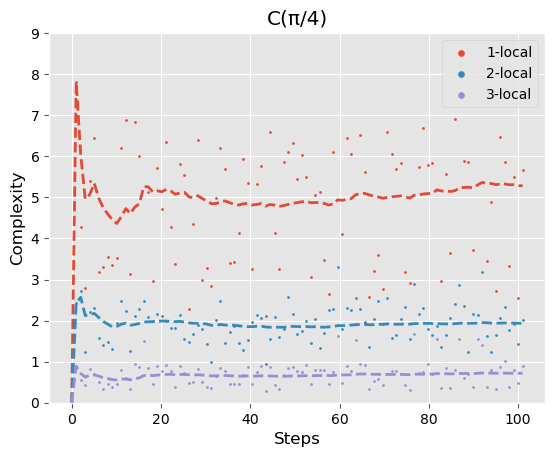

In [65]:
x = np.linspace(0,len(nc_1l)+1,len(nc_1l)+1)
z1=[0 if i==0 else nc_1l[i-1] for i in range(len(nc_1l)+1)]
z2=[0 if i==0 else nc_2l[i-1] for i in range(len(nc_1l)+1)]
z3=[0 if i==0 else nc_3l[i-1] for i in range(len(nc_1l)+1)]
y1=[0 if i==0 else np.cumsum(nc_1l)[i-1]/i for i in range(len(nc_1l)+1)]
y2=[0 if i==0 else np.cumsum(nc_2l)[i-1]/i for i in range(len(nc_1l)+1)]
y3=[0 if i==0 else np.cumsum(nc_3l)[i-1]/i for i in range(len(nc_1l)+1)]
plt.scatter(x,z1,s=2)
plt.scatter(x,z2,s=2)
plt.scatter(x,z3,s=2)
plt.plot(x,y1,linestyle='--',linewidth=2)
plt.plot(x,y2,linestyle='--',linewidth=2)
plt.plot(x,y3,linestyle='--',linewidth=2)
plt.ylim([0,9])
plt.style.use('ggplot')
plt.xlabel('Steps',color='black')
plt.ylabel('Complexity',color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('C(π/4)')
plt.legend(['1-local','2-local','3-local'],markerscale=3)
plt.savefig('comp_step_wise.pdf')
plt.show()

In [66]:
np.savetxt('nc_1l.txt',z1,delimiter=",")
np.savetxt('nc_2l.txt',z2,delimiter=",")
np.savetxt('nc_3l.txt',z3,delimiter=",")

#data=np.loadtxt('nc_1l.txt', dtype='complex',delimiter=",")

# Complexity for the step wise evolution.

/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


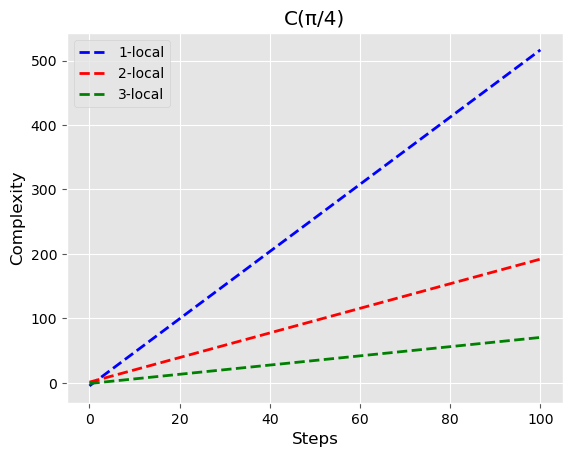

In [67]:
x = np.linspace(0,len(nc_1l),len(nc_1l))
y1=np.cumsum(nc_1l)
y2=np.cumsum(nc_2l)
y3=np.cumsum(nc_3l)
a1, b1=np.polyfit(x,y1,1)
a2, b2=np.polyfit(x,y2,1)
a3, b3=np.polyfit(x,y3,1)
plt.style.use('ggplot')
plt.xlabel('Steps',color='black')
plt.ylabel('Complexity',color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('C(π/4)')
plt.plot(x,a1*x+b1,color='blue',linestyle='--',linewidth=2)
plt.plot(x,a2*x+b2,color='red',linestyle='--',linewidth=2)
plt.plot(x,a3*x+b3,color='green',linestyle='--',linewidth=2)
plt.legend(['1-local','2-local','3-local'])
plt.savefig('comp_step.pdf')
plt.show()

# Complexity for $U=e^{-i H t}$ as a time evolution

In [54]:
span=100
NC_1l=np.zeros(span,dtype='complex')
NC_2l=np.zeros_like(NC_1l,dtype='complex')
NC_3l=np.zeros_like(NC_1l,dtype='complex')
sample_size=800

for i in range(span):
    
    U= Sample_Gen(ϕ[i+1],sample_size)
    NC_1l[i],x1 = min_complexity(U,1)
    NC_2l[i],x2 = min_complexity(U,2)
    NC_3l[i],x3 = min_complexity(U,3)

/var/folders/5t/172y__895xnc8hg5yllf04_h0000gn/T/ipykernel_74785/1879913389.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  nc[i]=complexity(U[i],x)


/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


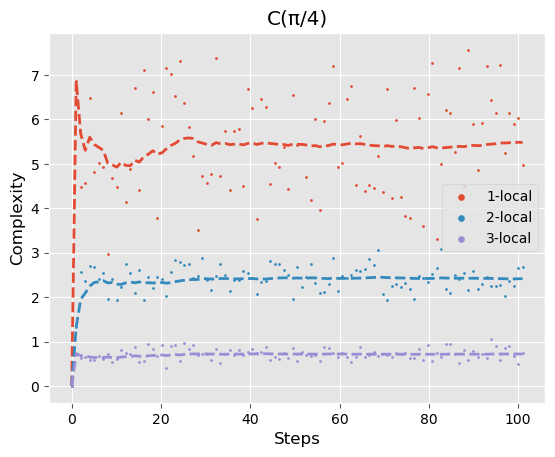

In [60]:
x = np.linspace(0,len(NC_1l)+1,len(NC_1l)+1)
z1=[0 if i==0 else NC_1l[i-1] for i in range(len(NC_1l)+1)]
z2=[0 if i==0 else NC_2l[i-1] for i in range(len(NC_1l)+1)]
z3=[0 if i==0 else NC_3l[i-1] for i in range(len(NC_1l)+1)]
y1=[0 if i==0 else np.cumsum(NC_1l)[i-1]/i for i in range(len(NC_1l)+1)]
y2=[0 if i==0 else np.cumsum(NC_2l)[i-1]/i for i in range(len(NC_1l)+1)]
y3=[0 if i==0 else np.cumsum(NC_3l)[i-1]/i for i in range(len(NC_1l)+1)]
plt.style.use('ggplot')
plt.scatter(x,z1,s=2)
plt.scatter(x,z2,s=2)
plt.scatter(x,z3,s=2)
plt.plot(x,y1,linestyle='--',linewidth=2)
plt.plot(x,y2,linestyle='--',linewidth=2)
plt.plot(x,y3,linestyle='--',linewidth=2)
plt.xlabel('Steps',color='black')
plt.ylabel('Complexity',color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('C(π/4)')
plt.legend(['1-local','2-local','3-local'], markerscale=3)
plt.savefig('comp_U.pdf')
plt.show()

In [63]:
np.savetxt('NCcap_1l.txt',z1,delimiter=",")
np.savetxt('NCcap_2l.txt',z2,delimiter=",")
np.savetxt('NCcap_3l.txt',z3,delimiter=",")

In [19]:
np.round(1j*logm(U_t1l[0]),8)

array([[ 0.03880378+0.j        ,  0.08908523-0.51266892j,
         1.29908519-0.58138966j, -0.2652626 +0.80502767j],
       [ 0.08908523+0.51266892j,  0.34256809+0.j        ,
         0.21632813-0.05987224j,  0.6312129 -0.1837489j ],
       [ 1.29908519+0.58138966j,  0.21632813+0.05987224j,
        -0.73865572-0.j        ,  0.09702811+0.62352382j],
       [-0.2652626 -0.80502767j,  0.6312129 +0.1837489j ,
         0.09702811-0.62352382j,  0.35728385-0.j        ]])

# Hamiltonian formulation
We take the hamiltonian for the step wise evolution to be,
$$ H_{t+1}=i\log(U_{t+1}U_t^\dagger)$$
and we further take,
$$ H_{t}= \sum_i J_i(t) T_i\,,$$
where $J_i$ are the couplings. Hamil(U) computes the couplings $J_i(t)$ as a function of the time step $t$. H1(U) computes the corresponding eigenvalues $\{\lambda_i\}$ as a function of the time step.

In [71]:
def Hamil(U):
    ss=[]
    for i in range(len(U)):
        u1=logm(U[i])
        sol=np.array([1j/4*(u1[0, 2] + u1[1, 3] + u1[2, 0] + u1[3, 1]), 1/4*(-u1[0, 2] - u1[1, 3] + u1[2, 0] + u1[3, 1]), 
        1j/4*(u1[0, 1] + u1[1, 0] - u1[2, 3] - u1[3, 2]), 1/4*(-u1[0, 1] + u1[1, 0] + u1[2, 3] - u1[3, 2]), -(1j/2)*(u1[0, 0] + u1[1, 1]), 
        1/4*(-u1[0, 3] - u1[1, 2] + u1[2, 1] + u1[3, 0]), -(1j/4)*(u1[0, 3] + u1[1, 2] + u1[2, 1] + u1[3, 0]),-1j/4*(u1[0, 3] - u1[1, 2] - u1[2, 1] + u1[3, 0]), 
        1/4*(u1[0, 3] - u1[1, 2] + u1[2, 1] - u1[3, 0]), -(1j/2)*(u1[0, 0] + u1[2, 2]), 1j/4*(u1[0, 1] + u1[1, 0] + u1[2, 3] + u1[3, 2]), 
        1/4*(-u1[0, 1] + u1[1, 0] - u1[2, 3] + u1[3, 2]), 1j/4*(u1[0, 2] - u1[1, 3] + u1[2, 0] - u1[3, 1]), 
        1/4*(-u1[0, 2] + u1[1, 3] + u1[2, 0] - u1[3, 1]), -(1j/2)*(u1[1, 1] + u1[2, 2])])
        ss.append(sol)
    return ss    

In [68]:
def H1(U):
    s1=[]
    for i in range(len(U)):
        u1=np.round(LA.eigvals(1j*logm(U[i])),9)
        s1.append(u1)
    return s1    

In [72]:
t1_1l=[H1(U_t1l)[i][0] for i in range(len(H1(U_t1l)))]
t2_1l=[H1(U_t1l)[i][1] for i in range(len(H1(U_t1l)))]
t3_1l=[H1(U_t1l)[i][2] for i in range(len(H1(U_t1l)))]
t4_1l=[H1(U_t1l)[i][3] for i in range(len(H1(U_t1l)))]

t1_2l=[H1(U_t2l)[i][0] for i in range(len(H1(U_t2l)))]
t2_2l=[H1(U_t2l)[i][1] for i in range(len(H1(U_t2l)))]
t3_2l=[H1(U_t2l)[i][2] for i in range(len(H1(U_t2l)))]
t4_2l=[H1(U_t2l)[i][3] for i in range(len(H1(U_t2l)))]

t1_3l=[H1(U_t3l)[i][0] for i in range(len(H1(U_t3l)))]
t2_3l=[H1(U_t3l)[i][1] for i in range(len(H1(U_t3l)))]
t3_3l=[H1(U_t3l)[i][2] for i in range(len(H1(U_t3l)))]
t4_3l=[H1(U_t3l)[i][3] for i in range(len(H1(U_t3l)))]

In [83]:
r1_1l=[np.cumsum(t1_1l)[i]/(1+i) for i in range(len(t1_1l))]
r2_1l=[np.cumsum(t2_1l)[i]/(1+i) for i in range(len(t2_1l))]
r3_1l=[np.cumsum(t3_1l)[i]/(1+i) for i in range(len(t1_1l))]
r4_1l=[np.cumsum(t4_1l)[i]/(1+i) for i in range(len(t1_1l))]

r1_2l=[np.cumsum(t1_2l)[i]/(1+i) for i in range(len(t1_1l))]
r2_2l=[np.cumsum(t2_2l)[i]/(1+i) for i in range(len(t2_1l))]
r3_2l=[np.cumsum(t3_2l)[i]/(1+i) for i in range(len(t1_1l))]
r4_2l=[np.cumsum(t4_2l)[i]/(1+i) for i in range(len(t1_1l))]

r1_3l=[np.cumsum(t1_3l)[i]/(1+i) for i in range(len(t1_1l))]
r2_3l=[np.cumsum(t2_3l)[i]/(1+i) for i in range(len(t2_1l))]
r3_3l=[np.cumsum(t3_3l)[i]/(1+i) for i in range(len(t1_1l))]
r4_3l=[np.cumsum(t4_3l)[i]/(1+i) for i in range(len(t1_1l))]


# Eigenvalues for $k-$ local step Hamiltonian

/Users/kallolsen/opt/anaconda3/envs/Qiskit_QC/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


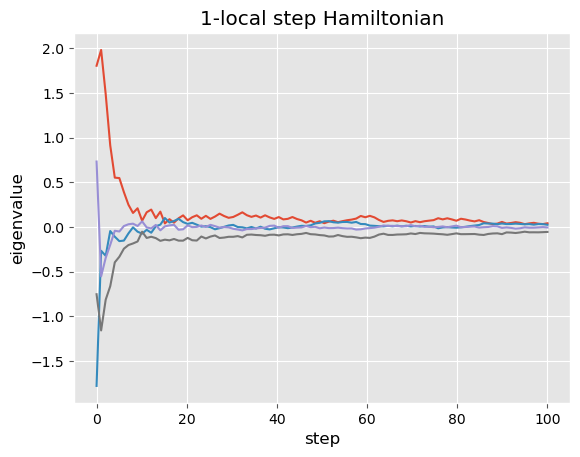

In [90]:
x=np.linspace(0,span,span)
plt.plot(x,r1_1l)
plt.plot(x,r2_1l)
plt.plot(x,r3_1l)
plt.plot(x,r4_1l)
#plt.plot(x,r1_2l)
#plt.plot(x,r2_2l)
#plt.plot(x,r3_2l)
#plt.plot(x,r4_2l)
#plt.plot(x,r1_3l)
#plt.plot(x,r2_3l)
#plt.plot(x,r3_3l)
#plt.plot(x,r4_3l)
plt.xlabel('step', color='black')
plt.ylabel('eigenvalue',color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.title('1-local step Hamiltonian')
#plt.legend(['1-local','2-local','3-local'])
plt.savefig('eigplot.pdf')
plt.show()

# A quantum circuit for the Unitary operator
Given the form of the unitary operator, we can and are going to attach a corresponding quantum circuit to it. 

In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [143]:
Circuit_Depth1l = []
for i in range(span): 
    qc = QuantumCircuit(2)
    qc.unitary(U_t1l[i],([0,1]))
    trans_qc = transpile(qc,basis_gates = ['cx','u3'],optimization_level = 3)
    # print('\n')
    # print(trans_qc)
    # print('\n')
    Circuit_Depth1l.append(trans_qc.depth()) 
    print(trans_qc)

global phase: 3.742
     ┌───────────────────────────┐          ┌───────────────────────┐         »
q_0: ┤ U3(1.0987,-2.863,-1.9906) ├───■──────┤ U3(0.80234,-π/2,-π/2) ├──────■──»
     ├───────────────────────────┴┐┌─┴─┐┌───┴───────────────────────┴───┐┌─┴─┐»
q_1: ┤ U3(2.5123,0.88746,-2.6376) ├┤ X ├┤ U3(0.93487,-0.59413,-0.72118) ├┤ X ├»
     └────────────────────────────┘└───┘└───────────────────────────────┘└───┘»
«         ┌───────────────────┐         ┌─────────────────────────────┐
«q_0: ────┤ U3(0.58555,0,π/2) ├──────■──┤ U3(1.7215,-1.6841,0.018435) ├
«     ┌───┴───────────────────┴───┐┌─┴─┐└┬───────────────────────────┬┘
«q_1: ┤ U3(2.0908,-2.4468,2.6039) ├┤ X ├─┤ U3(2.2243,1.7933,0.15049) ├─
«     └───────────────────────────┘└───┘ └───────────────────────────┘ 
global phase: 0.13011
      ┌────────────────────────────┐        ┌───────────────────────┐        »
q_0: ─┤ U3(1.2731,-2.2198,-1.5623) ├──■─────┤ U3(0.60459,-π/2,-π/2) ├─────■──»
     ┌┴────────────────────────────┤┌─┴─

global phase: 5.7697
     ┌───────────────────────────┐         ┌───────────────────────┐         »
q_0: ┤ U3(1.4942,-2.3235,1.5055) ├──■──────┤ U3(0.59309,-π/2,-π/2) ├──────■──»
     ├───────────────────────────┤┌─┴─┐┌───┴───────────────────────┴───┐┌─┴─┐»
q_1: ┤ U3(1.3881,-2.2524,2.4353) ├┤ X ├┤ U3(0.73162,-0.065267,-1.4832) ├┤ X ├»
     └───────────────────────────┘└───┘└───────────────────────────────┘└───┘»
«         ┌────────────────────┐        ┌────────────────────────────┐
«q_0: ────┤ U3(0.017935,0,π/2) ├─────■──┤ U3(1.1239,1.5048,-0.96415) ├
«     ┌───┴────────────────────┴──┐┌─┴─┐├───────────────────────────┬┘
«q_1: ┤ U3(2.0908,-2.4468,2.6039) ├┤ X ├┤ U3(1.5667,1.5662,0.94659) ├─
«     └───────────────────────────┘└───┘└───────────────────────────┘ 
global phase: 0.3819
     ┌───────────────────────────┐        ┌───────────────────────┐         »
q_0: ┤ U3(1.702,-0.74732,2.0537) ├──■─────┤ U3(0.36016,-π/2,-π/2) ├──────■──»
     ├───────────────────────────┤┌─┴─┐┌──┴─────────

In [ ]:
Circuit_Depth2l = []
for i in range(span): 
    qc1 = QuantumCircuit(2)
    qc1.unitary(U_t2l[i],([0,1]))
    trans_qc = transpile(qc1,basis_gates = ['cx','u3'],optimization_level = 3)
    # print('\n')
    # print(trans_qc)
    # print('\n')
    Circuit_Depth2l.append(trans_qc.depth())   

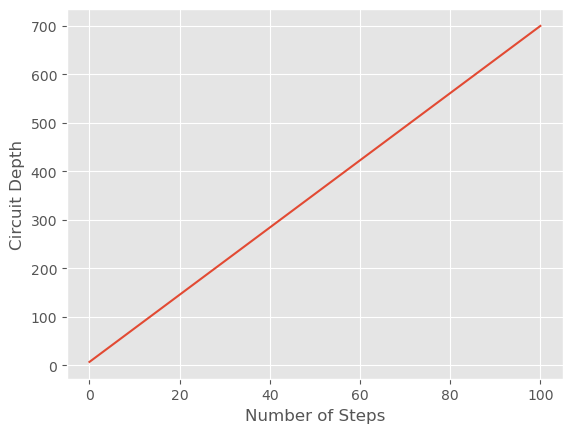

In [135]:
xx=np.linspace(0,span,span)
#plt.plot(xx,np.cumsum(Circuit_Depth1l))
#plt.style.use('ggplot')
plt.plot(xx,np.cumsum(Circuit_Depth2l))
plt.xlabel('Number of Steps')
plt.ylabel('Circuit Depth')
plt.show()

In [145]:

qc=QuantumCircuit(2)
qc.unitary(U_t1l[2],([0,1]))
tqc=transpile(qc,basis_gates=['cx','u3'])
tqc.draw("mpl")
qc.draw("mpl").savefig('unit.pdf')

In [146]:
tqc.draw("mpl").savefig('comp.pdf')

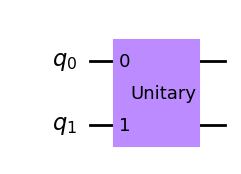

In [147]:
qc.draw("mpl")

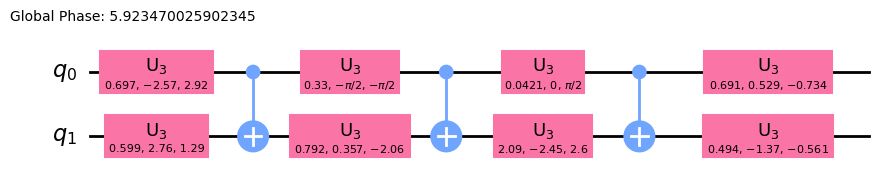

In [148]:
tqc.draw("mpl")

In [55]:
qc=QuantumCircuit(2)
qc.unitary(U_t1l[2],([0,1]))
tqc=transpile(qc,basis_gates=['u3','cx'],optimization_level=3)
tqc.draw("mpl")
qc.draw("mpl").savefig('unit.pdf')

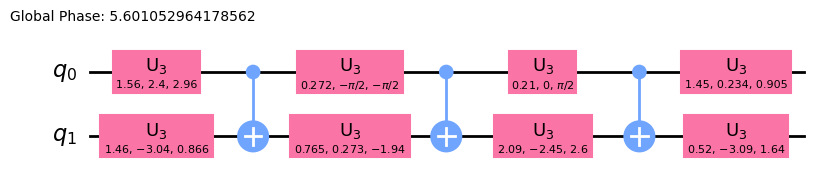

In [56]:
tqc.draw("mpl")